In [ ]:
import torch
torch.cuda.is_available()

True

In [13]:
!git pull https://github.com/Lolleeee/MIEEG

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 440 bytes | 440.00 KiB/s, done.
From https://github.com/Lolleeee/MIEEG
 * branch            HEAD       -> FETCH_HEAD
Updating 1e1542a..f378d38
Fast-forward
 packages/train/loss.py | 5 +++--
 1 file changed, 3 insertions(+), 2 deletions(-)


In [2]:
!git clone https://github.com/Lolleeee/MIEEG
import os 
os.chdir("MIEEG")


Cloning into 'MIEEG'...
remote: Enumerating objects: 945, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 945 (delta 62), reused 55 (delta 30), pack-reused 849 (from 1)
Receiving objects: 100% (945/945), 38.79 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (614/614), done.


In [14]:
import numpy as np
matrix = np.array(
    [
        [None, "Fp1", None, "Fp2", None],
        ["F7", "F3", "Fz", "F4", "F8"],
        ["FC5", "FC1", "Cz", "FC2", "FC6"],
        ["T7", "C3", "CP1", "C4", "T8"],
        ["TP9", "CP5", "CP2", "CP6", "TP10"],
        ["P7", "P3", "Pz", "P4", "P8"],
        ["PO9", "O1", "Oz", "O2", "PO10"],
    ]
)



In [ ]:
from packages.models.vqae import CompactVQVAE_EEGChunk, SequenceProcessor
from packages.train.loss import VQVAELoss, SequenceVQVAELoss
chunk_ae = CompactVQVAE_EEGChunk(
    in_channels=25,
    input_spatial=(7, 5, 32),
    embedding_dim=128,
    codebook_size=512
)


In [ ]:
from packages.train.training import train_model
from packages.train.loss import CustomMSELoss, PerceptualLoss, CustomL1Loss
from packages.io.file_loader import get_data_loaders
import torch
import os

from packages.data_objects.dataset import TorchDataset

dataset_path = "/kaggle/input/64nooverlap05"
# Dummy training loop
optimizer = torch.optim.AdamW

mae = torch.nn.L1Loss
criterion = VQVAELoss(
    recon_loss_type='mse',
    recon_weight=1.0
)
config = {
    'weight_decay': 1e-4,
    'epochs': 50,
    'EarlyStopping' : {'patience': 20, 'min_delta': 0.01},
    'BackupManager': {'backup_interval': 10, 'backup_path': './model_backups'},
    'ReduceLROnPlateau': {'mode': 'min', 'patience': 5, 'factor': 0.0},
    'history_plot': {'plot_type': 'extended', 'save_path': './training_history'},
    'grad_clip': 1.0,
    'use_amp': False,
    'grad_logging_interval' : None,
    'asym_lr': None
}

dataset = TorchDataset(root_folder=dataset_path)

train_loader, val_loader, _ = get_data_loaders(dataset, sets_size={'train': 0.7, 'val': 0.3, 'test': 0.}, norm_axes=(0, 4), batch_size = 128)

Calculating global parameters: 100%|██████████| 169/169 [00:14<00:00, 11.33it/s]


In [17]:
model = train_model(model, train_loader=train_loader, val_loader=val_loader, loss_criterion=criterion, optimizer=optimizer, config=config, metrics={})

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/169 [00:00<?, ?it/s]

RuntimeError: shape '[128, 25, 128]' is invalid for input of size 32768

torch.Size([128, 25, 7, 5, 64])


/kaggle/working/MIEEG/packages/train/testing.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).to(device)


ValueError: x and y must be the same size

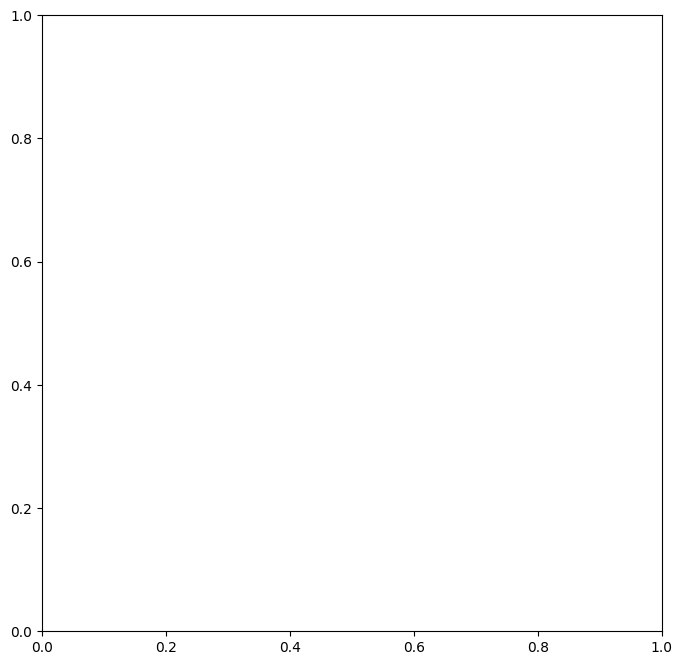

In [14]:
from packages.train.testing import autoencoder_test_plots
autoencoder_test_plots(model, val_loader, nsamples = 5)

In [12]:
class mse():
    def __init__(self):
        self.criterion = torch.nn.MSELoss()
    
    def __call__(self, outputs, targets):
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        return self.criterion(outputs, targets)

In [13]:
criterion = CustomL1Loss(scale=1, masked=True, matrix=matrix )
config = {
    'weight_decay': 1e-4,
    'epochs': 50,
    'EarlyStopping' : {'patience': 20, 'min_delta': 0.01},
    'BackupManager': {'backup_interval': 10, 'backup_path': './model_backups'},
    'ReduceLROnPlateau': {'mode': 'min', 'patience': 5, 'factor': 0.0},
    'history_plot': {'plot_type': 'extended', 'save_path': './training_history'},
    'grad_clip': 1.0,
    'use_amp': False,
    'grad_logging_interval' : None,
    'asym_lr': None,
    'lr': 1e-4
}
metrics = {
    'MSE': mse()
}
model = train_model(model, train_loader=train_loader, val_loader=val_loader, loss_criterion=criterion, optimizer=optimizer, config=config, metrics={})

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/169 [00:00<?, ?it/s]

[INFO] Train Loss: 0.2213
[INFO] Val Loss: 0.2575
[INFO] Best model saved at epoch 1 with metric 0.2575


Training Batches:   0%|          | 0/169 [00:00<?, ?it/s]

[INFO] Train Loss: 0.2201
[INFO] Val Loss: 0.2572
[INFO] Best model saved at epoch 2 with metric 0.2572


Training Batches:   0%|          | 0/169 [00:00<?, ?it/s]

[INFO] Train Loss: 0.2191
[INFO] Val Loss: 0.2570
[INFO] Best model saved at epoch 3 with metric 0.2570


Training Batches:   0%|          | 0/169 [00:00<?, ?it/s]

[INFO] Train Loss: 0.2182
[INFO] Val Loss: 0.2568
[INFO] Best model saved at epoch 4 with metric 0.2568


Training Batches:   0%|          | 0/169 [00:00<?, ?it/s]

[INFO] Train Loss: 0.2173
[INFO] Val Loss: 0.2567
[INFO] Best model saved at epoch 5 with metric 0.2567


Training Batches:   0%|          | 0/169 [00:00<?, ?it/s]

KeyboardInterrupt: 

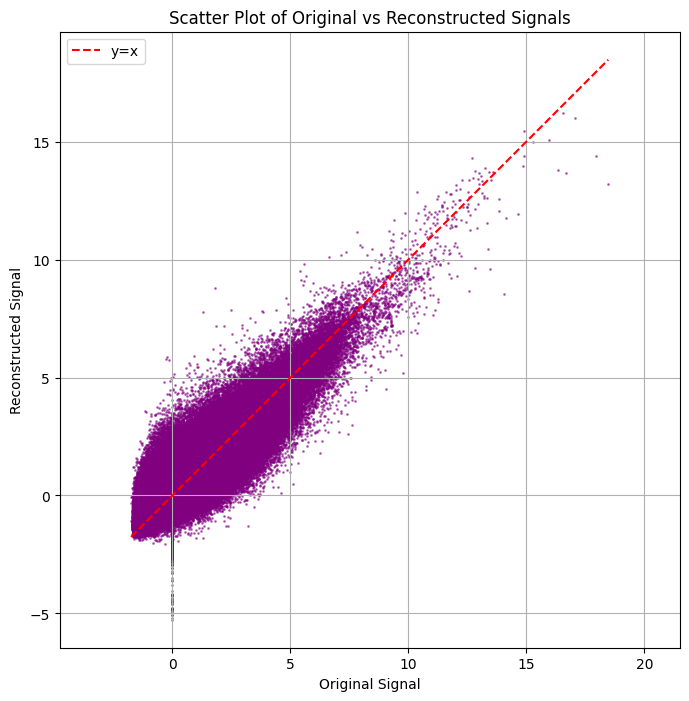

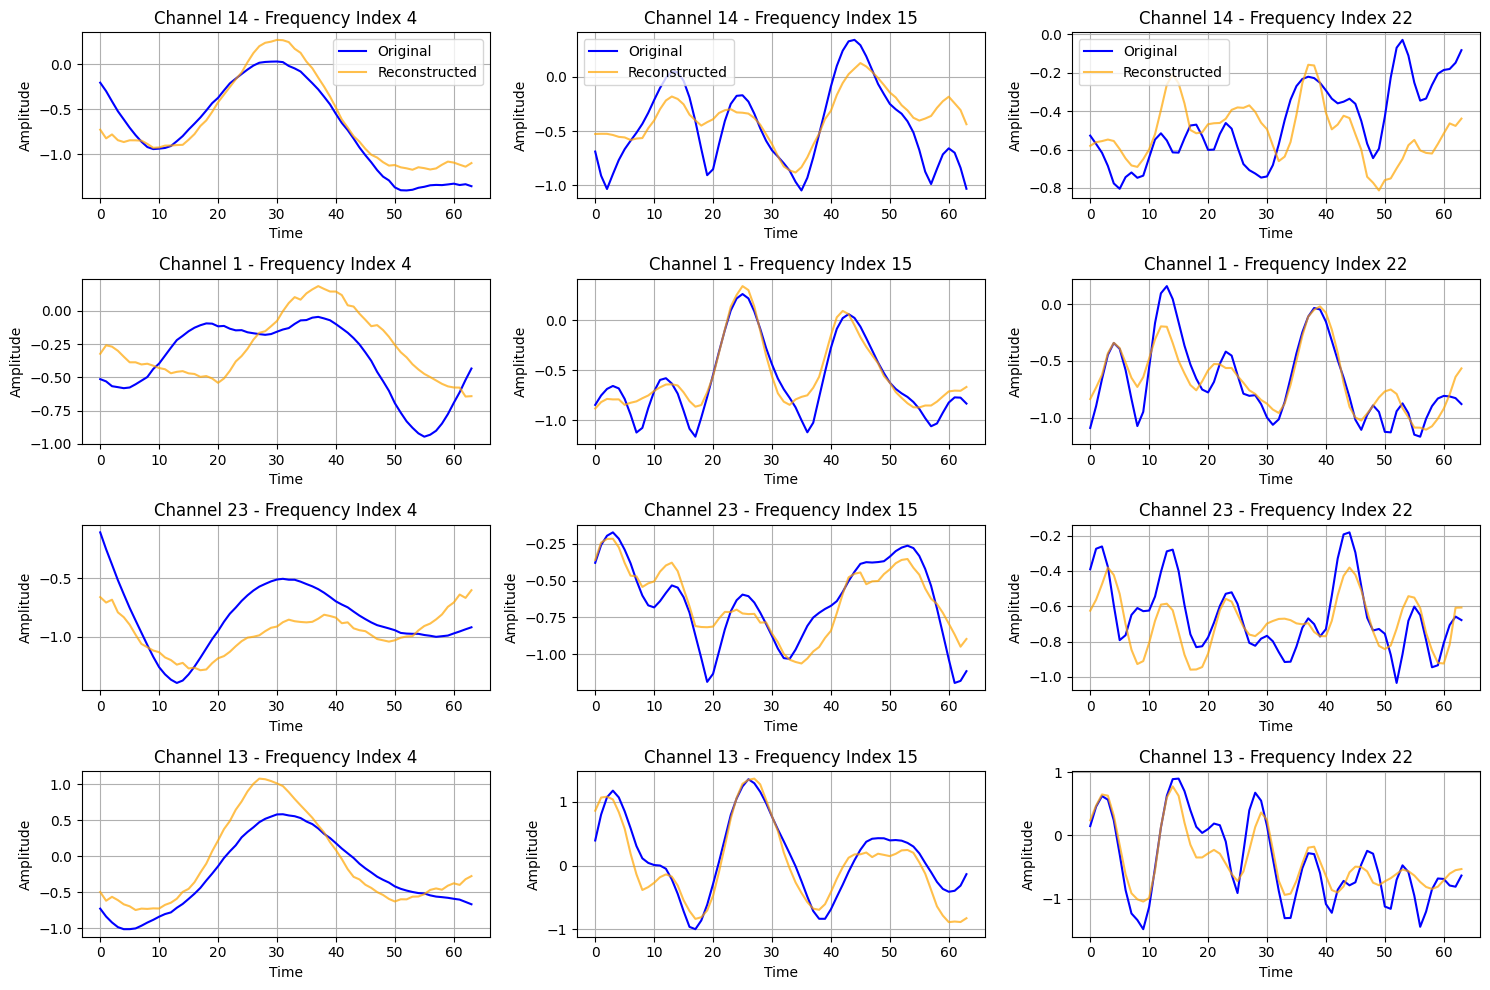

In [17]:
from packages.plotting.reconstruction_plots import plot_reconstruction_slices
import numpy as np

import torch
from packages.plotting.reconstruction_plots import plot_reconstruction_scatter

# --- Load model and parameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.load_state_dict(torch.load("/kaggle/working/MIEEG/model_backups/best_model_epoch_25.pt", map_location="cpu"))
model.eval()
# --- Prepare input data ---
input_data = next(iter(val_loader))  # Replace with your actual input
input_data = input_data.to(device)
# --- Get reconstruction ---
with torch.no_grad():
    reconstructed = model(input_data)

# --- Plot reconstruction scatter ---
plot_reconstruction_scatter(input_data, reconstructed)

batch_size = config.get('batch_size', 31)
i = np.random.randint(0, batch_size)
if isinstance(reconstructed, tuple):
    reconstructed = reconstructed[0]
plot_reconstruction_slices(input_data[i,...], reconstructed[i,...], freqs=[4,15,22])